# Risk analysis with non-normal distribution

In this example, a resistor-capacitor (RC) circuit is constructed from off-the-shelf components. The time constant of the circuit is calculated with

$\tau = R(C_1 + C_2)$.

The components are given with tolerances, and so are interpreted as uniform distributions. Using the GUM method treats all uncertainties as normal distributions and gives a normal distribution combined uncertainty. The Monte Carlo method accounts for the non-normal distributions, producing a combined distribution that looks nearly trapezoidal. This notebook compares the risk analysis (Probability of false accept and reject) using both the normal approximation and the full trapezoidal distribution.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import suncal
from suncal import risk

## Find uncertainty

First, we find the combined uncertainty in the time constant for the RC circuit in milliseconds.

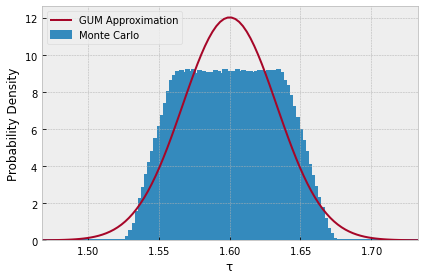

In [2]:
u = suncal.UncertCalc('tau = R*(C1+C2)')
u.set_input('R', nom=5, a='1%', dist='uniform')      # kOhm
u.set_input('C1', nom=0.22, a='5%', dist='uniform')  # uF
u.set_input('C2', nom=0.1, a='1%', dist='uniform')   # uF
u.calculate()
u.out.plot_pdf()

## Risk of PFA/PFR for Normal/GUM approximation

Now, consider specification limits of $1.55 < \tau < 1.65$. Each RC circuit is measured with a test instrument having uncertainty of 0.01 ms. What is the probability of false accept and false reject assuming the GUM's (normal) uncertainty result?

PFA: 2.33%
PFR: 4.06%


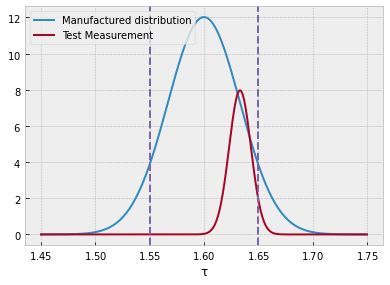

In [3]:
out = u.out.gum
LL = 1.55
UL = 1.65

dtest = stats.norm(loc=out.nom().magnitude+out.uncert().magnitude, scale=.01)   # Scope with 10ns uncertainty in time. loc doesn't matter -- will integrate over all loc
dproc = stats.norm(loc=out.nom().magnitude, scale=out.uncert().magnitude)
PFA = risk.PFA(dproc, dtest, LL, UL) * 100
PFR = risk.PFR(dproc, dtest, LL, UL) * 100
print('PFA: {:.2f}%'.format(PFA))
print('PFR: {:.2f}%'.format(PFR))

xx = np.linspace(1.45, 1.75, num=200)
plt.plot(xx, dproc.pdf(xx), label='Manufactured distribution')
plt.plot(xx, dtest.pdf(xx) / 5, label='Test Measurement')   # Scaled down so they're approx the same height
plt.legend(loc='upper left', fontsize=10)
plt.xlabel(r'$\tau$')
plt.axvline(LL, ls='--', color='C2')
plt.axvline(UL, ls='--', color='C2');

## Risk of PFA/PFR for Monte Carlo distribution

Using the Monte Carlo distribution result, what is the PFA/PFR? Because the distribution is already discrete/approximate, we can use the `approx=True` argument to PFA() and PFR() to speed up the calculation.

PFA: 3.32%
PFR: 5.92%


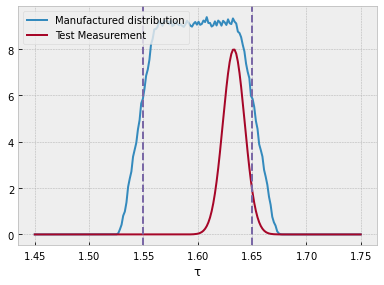

In [4]:
samples = u.out.mc.samples().magnitude
dproc = stats.rv_histogram(np.histogram(samples, bins='auto'))   # Process distribution based on Monte Carlo histogram

PFA = risk.PFA(dproc, dtest, LL, UL, approx=True) * 100
PFR = risk.PFR(dproc, dtest, LL, UL, approx=True) * 100
print('PFA: {:.2f}%'.format(PFA))
print('PFR: {:.2f}%'.format(PFR))

xx = np.linspace(1.45, 1.75, num=200)
plt.plot(xx, dproc.pdf(xx), label='Manufactured distribution')
plt.plot(xx, dtest.pdf(xx) / 5, label='Test Measurement')
plt.legend(loc='upper left', fontsize=10)
plt.xlabel(r'$\tau$')
plt.axvline(LL, ls='--', color='C2')
plt.axvline(UL, ls='--', color='C2');

By accounting for the distribution, the false-accept probability is increased by about 1%!